In [1]:
import os
import sys
current_directory = os.getcwd()
if not os.path.exists(current_directory + '\\experimental_data'):
    os.makedirs(current_directory + '\\experimental_data')
    os.makedirs(current_directory + '\\experimental_data\\plots')
    os.makedirs(current_directory + '\\experimental_data\\results')
sys.path.append(current_directory.replace('experiments', ''))
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.set_loglevel('WARNING')
from run import execute_simulation, create_experiment_snapshots, execute_ai_model, single_mtd_simulation, single_mtd_ai_simulation
from mtdnetwork.mtd.completetopologyshuffle import CompleteTopologyShuffle
from mtdnetwork.mtd.ipshuffle import IPShuffle
from mtdnetwork.mtd.hosttopologyshuffle import HostTopologyShuffle
from mtdnetwork.mtd.portshuffle import PortShuffle
from mtdnetwork.mtd.osdiversity import OSDiversity
from mtdnetwork.mtd.servicediversity import ServiceDiversity
from mtdnetwork.mtd.usershuffle import UserShuffle
from mtdnetwork.mtd.osdiversityassignment import OSDiversityAssignment
import logging
import pandas as pd
import numpy as np
from math import pi


logging.basicConfig(format='%(message)s', level=logging.INFO)

In [2]:
create_experiment_snapshots([25, 50, 75, 100])

In [3]:
# Learning Parameters
epsilon = 1.0  # exploration rate

# Simulator Settings
start_time = 0
finish_time = 3000
mtd_interval = 100
total_nodes = 300
new_network = True
features = ["host_compromise_ratio", "exposed_endpoints", "attack_path_exposure",  "overall_asr_avg", "roa", "shortest_path_variability", "risk"]
model = "main_network_final_host_compromise_ratio#exposed_endpoints#attack_path_exposure#overall_asr_avg#roa#shortest_path_variability#risk"
trial = 2

mtd_strategies = [
    None,
    CompleteTopologyShuffle,
    # HostTopologyShuffle,
    IPShuffle,
    OSDiversity,
    # PortShuffle,
    # OSDiversityAssignment,
    ServiceDiversity,
    # UserShuffle
]



In [4]:
# nomtd = single_mtd_simulation("nomtd", [None], checkpoint=list(np.arange(0.01, 1.01, 0.01)))

In [5]:
# pd.DataFrame(nomtd)

In [6]:
# len(nomtd)

In [7]:
# mtd_ai = single_mtd_ai_simulation('mtd_ai', model, start_time, finish_time, total_nodes, new_network = new_network)

In [8]:
# pd.DataFrame(mtd_ai)

In [9]:
# len(mtd_ai)

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class RadarPlot:
    def __init__(self, epsilon, start_time, finish_time, mtd_interval, total_nodes, new_network, features, model, trial):
        # Learning Parameters
        self.epsilon = epsilon  # exploration rate

        # Simulator Settings
        self.start_time = start_time
        self.finish_time = finish_time
        self.mtd_interval = mtd_interval
        self.schemes = [ 'mtd_ai', 'simultaneous', 'random', 'alternative']
        self.total_nodes = total_nodes
        self.new_network = new_network
        self.features = features
        self.model = model
        self.trial = trial
        self.normalization_values = self.get_scheme_values('nomtd')
        self.mtd_strategies = [
            CompleteTopologyShuffle,
            # HostTopologyShuffle,
            IPShuffle,
            OSDiversity,
            # PortShuffle,
            # OSDiversityAssignment,
            ServiceDiversity,
            # UserShuffle
        ]




    def get_scheme_values(self, scheme):
        # Simulate and stack nomtd DataFrames
        dfs = []
        for _ in range(self.trial):
            if scheme == 'nomtd':
                mtd = pd.DataFrame(single_mtd_simulation(scheme, [None], checkpoint=list(np.arange(0.01, 1.01, 0.01)))).drop('Name', axis=1)
            elif scheme == 'mtd_ai':
                mtd = pd.DataFrame(single_mtd_ai_simulation('mtd_ai', model, start_time, finish_time, total_nodes, new_network = new_network)).drop('Name', axis=1)
            else:
                mtd = pd.DataFrame(single_mtd_simulation(scheme, self.mtd_strategies, checkpoint=list(np.arange(0.01, 1.01, 0.01)))).drop('Name', axis=1)
            dfs.append(mtd)
        stacked_nomtd = pd.concat(dfs, ignore_index=True)
        
        # Calculate median for normalization
        median_df = stacked_nomtd.groupby(['mtd_interval', 'network_size']).median()

        # Filter the DataFrame for mtd_interval = 100 and network_size = 25
        normalization_values = median_df.loc[(100, 25)].to_dict()

        return normalization_values

    def scale_metrics(self, metrics_dict, normalization_dict):
        # Define which metrics should be maximized and which should be minimized
        metrics_to_maximize = {'ASR', 'ROA', 'exposed_endpoints'}  
        metrics_to_minimize = {'host_compromise_ratio', 'time_to_compromise', 'attack_path_exposure'}  

        scaled_metrics = {}

        for key, value in metrics_dict.items():
            if key in normalization_dict:
                norm_value = normalization_dict[key]

                if norm_value != 0:
                    if key in metrics_to_maximize:
                        # Normalize by dividing the metric value by the normalization value
                        scaled_metrics[key] = value / norm_value
                    elif key in metrics_to_minimize:
                        # Inverse the ratio for metrics to be minimized
                        scaled_metrics[key] = 1 / (value / norm_value)
                    else:
                        # Handle cases where the metric is not in either category
                        scaled_metrics[key] = value / norm_value
                else:
                    # Handle the case where norm_value is zero
                    scaled_metrics[key] = 1  # Or any other placeholder value as needed
            else:
                # Handle cases where normalization value is not defined
                scaled_metrics[key] = value  # Or handle differently as needed

        return scaled_metrics


    def plot_single_radar(self, metrics_values, scheme, std_dev_values=None):
        labels = list(metrics_values.keys())
        values = list(metrics_values.values())
        num_vars = len(labels)

        # Compute angle for each axis
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        angles += angles[:1]  # Complete the circle
        values += values[:1]
        if std_dev_values:
            std_dev_values = list(std_dev_values.values())  # Assuming std_dev_values is also a dictionary
            std_dev_values += std_dev_values[:1]
        labels += labels[:1]  # Close the circle by repeating the first label

        # Create radar plot
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

        # Plot data
        ax.fill(angles, values, color='blue', alpha=0.25)
        ax.plot(angles, values, color='blue', linewidth=2, label=scheme)

        # Add error bars if provided
        if std_dev_values:
            for i in range(num_vars):
                angle = angles[i]
                value = values[i]
                error = std_dev_values[i]
                ax.errorbar(angle, value, yerr=error, fmt='o', color='blue', capsize=5, elinewidth=2)

        # Add score labels
        for i in range(num_vars):
            angle = angles[i]
            value = values[i]
            ax.text(angle, value + 0.05, f'{value:.2f}', horizontalalignment='center', size=10, color='black')

        # Labels
        ax.set_yticklabels([])
        ax.set_xticks(angles[:-1])  # Set ticks without the last angle
        ax.set_xticklabels(labels[:-1], rotation=45, ha='right')

        plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
        plt.show()


    def plot_comparison_radar(self, baseline_metrics):
        """
        Plot a radar chart comparing multiple schemes to a baseline.

        :param baseline_metrics: Dictionary of metrics for the baseline (e.g., no MTD).
        :param schemes_metrics: Dictionary where keys are scheme names and values are dictionaries of metrics.
        """
        # Convert baseline metrics to the format expected by the plot function
        baseline_labels = list(baseline_metrics.keys())
        baseline_values = list(baseline_metrics.values())
        num_vars = len(baseline_labels)

        # Compute angle for each axis
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        angles += angles[:1]  # Complete the circle
        baseline_values += baseline_values[:1]
        

        # Create a dictionary to store metrics for each scheme
        schemes_metrics = {}
        
        for scheme in self.schemes:
            if scheme == 'mtd_ai':
                metrics_values = single_mtd_ai_simulation('mtd_ai', model, start_time, finish_time, total_nodes, new_network = new_network)
            # Here you would normally call a function to get metrics for the scheme.
            # For demonstration, I'll use placeholder values.
            # Replace the following line with your actual metric retrieval.
            else:
                metrics_values = self.get_scheme_values(scheme)
            metrics_values = self.scale_metrics(metrics_dict=metrics_values, normalization_dict=self.normalization_values)
            
            # Store metrics values in the dictionary
            schemes_metrics[scheme] = metrics_values


        # Create radar plot
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
        
        # Plot baseline
        ax.fill(angles, baseline_values, color='grey', alpha=0.25, label='Baseline (No MTD)')
        ax.plot(angles, baseline_values, color='grey', linewidth=2, linestyle='--')

        # Plot each scheme
        colors = ['blue', 'green', 'red', 'orange']  # Define colors for each scheme
        for i, (scheme, metrics_values) in enumerate(schemes_metrics.items()):
            values = list(metrics_values.values())
            values += values[:1]  # Close the circle
            ax.fill(angles, values, color=colors[i % len(colors)], alpha=0.25, label=scheme)
            ax.plot(angles, values, color=colors[i % len(colors)], linewidth=2)

        # Add score labels
        for i in range(num_vars):
            angle = angles[i]
            value = baseline_values[i]
            ax.text(angle, value + 0.05, f'{value:.2f}', horizontalalignment='center', size=10, color='black')

        # Labels
        ax.set_yticklabels([])
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(baseline_labels[:-1], rotation=45, ha='right')

        plt.title(f"Comparison Radar Chart Against Baseline", size=15, color='black', y=1.1)
        plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
        plt.show()

In [27]:
# model = "main_network_all_features"
# features = ["host_compromise_ratio", "exposed_endpoints", "attack_path_exposure",  "overall_asr_avg", "roa", "shortest_path_variability", "risk"]
# for feature in features:
#     model = "main_network_" + feature
#     radar = RadarPlot(epsilon, start_time, finish_time, mtd_interval, total_nodes, new_network, features, model, trial=trial)
#     # Plot against all schemes
#     radar.plot_against_all_schemes()



In [28]:
radar = RadarPlot(epsilon, start_time, finish_time, mtd_interval, total_nodes, new_network, features, model, trial=trial)

NoMTD
NoMTD


MTD: CompleteTopologyShuffle triggered 0.0s
MTD: CompleteTopologyShuffle triggered 100.4s
MTD: Interrupted SCAN_PORT at 120.1s!
MTD: CompleteTopologyShuffle triggered 200.5s
MTD: CompleteTopologyShuffle triggered 300.5s
MTD: Interrupted EXPLOIT_VULN at 320.7s!
MTD: CompleteTopologyShuffle triggered 400.7s
MTD: CompleteTopologyShuffle triggered 501.1s
MTD: Interrupted EXPLOIT_VULN at 521.0s!
MTD: CompleteTopologyShuffle triggered 601.4s
MTD: CompleteTopologyShuffle triggered 702.1s
MTD: Interrupted EXPLOIT_VULN at 721.5s!
MTD: CompleteTopologyShuffle triggered 802.4s
MTD: CompleteTopologyShuffle triggered 902.8s
MTD: Interrupted EXPLOIT_VULN at 923.0s!
MTD: CompleteTopologyShuffle triggered 1003.3s
MTD: CompleteTopologyShuffle triggered 1104.2s
MTD: Interrupted EXPLOIT_VULN at 1123.4s!
MTD: CompleteTopologyShuffle triggered 1204.3s
MTD: CompleteTopologyShuffle triggered 1305.3s
MTD: Interrupted EXPLOIT_VULN at 1324.6s!
MTD: CompleteTopologyShuffle triggered 1405.9s
MTD: CompleteTopology

CompleteTopologyShuffle


MTD: IPShuffle triggered 0.0s
MTD: IPShuffle triggered 101.0s
MTD: Interrupted SCAN_PORT at 111.5s!
MTD: IPShuffle triggered 201.4s
MTD: IPShuffle triggered 301.9s
MTD: Interrupted EXPLOIT_VULN at 311.5s!
MTD: IPShuffle triggered 402.2s
MTD: IPShuffle triggered 502.2s
MTD: Interrupted SCAN_PORT at 513.4s!
MTD: IPShuffle triggered 602.3s
MTD: IPShuffle triggered 703.0s
MTD: Interrupted EXPLOIT_VULN at 712.5s!
MTD: IPShuffle triggered 803.6s
MTD: IPShuffle triggered 904.1s
MTD: Interrupted EXPLOIT_VULN at 914.0s!
MTD: IPShuffle triggered 1004.3s
MTD: IPShuffle triggered 1104.3s
MTD: Interrupted EXPLOIT_VULN at 1114.9s!
MTD: IPShuffle triggered 1204.4s
MTD: IPShuffle triggered 1304.6s
MTD: Interrupted SCAN_PORT at 1314.5s!
MTD: IPShuffle triggered 1404.6s
MTD: IPShuffle triggered 1506.5s
MTD: Interrupted EXPLOIT_VULN at 1514.7s!
MTD: IPShuffle triggered 1607.4s
MTD: IPShuffle triggered 1708.0s
MTD: Interrupted EXPLOIT_VULN at 1718.2s!
MTD: IPShuffle triggered 1808.9s
MTD: IPShuffle trigge

IPShuffle


MTD: OSDiversity triggered 7335.5s
MTD: OSDiversity triggered 7437.2s
MTD: OSDiversity triggered 7537.7s
MTD: OSDiversity triggered 7638.5s
MTD: OSDiversity triggered 7739.6s
MTD: OSDiversity triggered 7840.7s
MTD: OSDiversity triggered 7941.4s
MTD: OSDiversity triggered 8041.7s
MTD: OSDiversity triggered 8141.9s
MTD: OSDiversity triggered 8242.0s
MTD: OSDiversity triggered 8342.0s
MTD: OSDiversity triggered 8442.6s
MTD: OSDiversity triggered 8543.1s
MTD: OSDiversity triggered 8643.6s
MTD: OSDiversity triggered 8743.8s
MTD: OSDiversity triggered 8844.5s
MTD: OSDiversity triggered 8945.7s
MTD: OSDiversity triggered 9045.7s
MTD: OSDiversity triggered 9147.1s
MTD: OSDiversity triggered 9247.6s
MTD: OSDiversity triggered 9347.6s
MTD: OSDiversity triggered 9447.6s
MTD: OSDiversity triggered 9547.9s
MTD: OSDiversity triggered 9648.6s
MTD: OSDiversity triggered 9748.6s
MTD: OSDiversity triggered 9849.4s
MTD: OSDiversity triggered 9949.6s
MTD: OSDiversity triggered 10050.4s
MTD: OSDiversity tr

OSDiversity


MTD: ServiceDiversity triggered 0.0s
MTD: ServiceDiversity triggered 100.4s
MTD: ServiceDiversity triggered 200.5s
MTD: ServiceDiversity triggered 300.8s
MTD: ServiceDiversity triggered 400.8s
MTD: ServiceDiversity triggered 501.2s
MTD: ServiceDiversity triggered 601.7s
MTD: ServiceDiversity triggered 701.8s
MTD: ServiceDiversity triggered 803.9s
MTD: ServiceDiversity triggered 905.1s
MTD: ServiceDiversity triggered 1005.8s
MTD: ServiceDiversity triggered 1106.0s
MTD: ServiceDiversity triggered 1206.2s
MTD: ServiceDiversity triggered 1306.3s
MTD: ServiceDiversity triggered 1406.6s
MTD: ServiceDiversity triggered 1506.9s
MTD: ServiceDiversity triggered 1607.1s
MTD: ServiceDiversity triggered 1708.6s
MTD: ServiceDiversity triggered 1808.9s
MTD: ServiceDiversity triggered 1909.3s
MTD: ServiceDiversity triggered 2009.6s
MTD: ServiceDiversity triggered 2110.1s
MTD: ServiceDiversity triggered 2210.4s
MTD: ServiceDiversity triggered 2310.6s
MTD: ServiceDiversity triggered 2410.8s
MTD: Service

ServiceDiversity


MTD: Interrupted EXPLOIT_VULN at 2932.7s!
MTD: CompleteTopologyShuffle triggered 3012.3s
MTD: CompleteTopologyShuffle triggered 3112.4s
MTD: Interrupted EXPLOIT_VULN at 3132.6s!
MTD: CompleteTopologyShuffle triggered 3213.3s
MTD: CompleteTopologyShuffle triggered 3313.5s
MTD: Interrupted EXPLOIT_VULN at 3333.9s!
MTD: CompleteTopologyShuffle triggered 3413.9s
MTD: CompleteTopologyShuffle triggered 3514.7s
MTD: Interrupted SCAN_PORT at 3534.8s!
MTD: CompleteTopologyShuffle triggered 3614.7s
MTD: CompleteTopologyShuffle triggered 3714.9s
MTD: Interrupted ENUM_HOST at 3734.8s!
MTD: CompleteTopologyShuffle triggered 3814.9s
MTD: CompleteTopologyShuffle triggered 3915.0s
MTD: Interrupted EXPLOIT_VULN at 3936.3s!
MTD: CompleteTopologyShuffle triggered 4015.1s
MTD: CompleteTopologyShuffle triggered 4115.3s
MTD: Interrupted EXPLOIT_VULN at 4135.3s!
MTD: CompleteTopologyShuffle triggered 4215.5s
MTD: CompleteTopologyShuffle triggered 4315.7s
MTD: Interrupted BRUTE_FORCE at 4335.5s!
MTD: Complete

CompleteTopologyShuffle


MTD: IPShuffle triggered 12966.6s
MTD: Interrupted SCAN_PORT at 12977.1s!
MTD: IPShuffle triggered 13066.8s
MTD: IPShuffle triggered 13167.3s
MTD: Interrupted SCAN_PORT at 13177.1s!
MTD: IPShuffle triggered 13268.9s
MTD: IPShuffle triggered 13369.6s
MTD: Interrupted SCAN_PORT at 13379.5s!
MTD: IPShuffle triggered 13469.9s
MTD: IPShuffle triggered 13570.1s
MTD: Interrupted SCAN_PORT at 13580.6s!
MTD: IPShuffle triggered 13672.0s
MTD: IPShuffle triggered 13772.0s
MTD: Interrupted SCAN_PORT at 13782.0s!
MTD: IPShuffle triggered 13872.2s
MTD: IPShuffle triggered 13972.3s
MTD: Interrupted SCAN_PORT at 13982.6s!
MTD: IPShuffle triggered 14073.2s
MTD: IPShuffle triggered 14173.4s
MTD: Interrupted SCAN_PORT at 14183.2s!
MTD: IPShuffle triggered 14273.5s
MTD: IPShuffle triggered 14374.0s
MTD: Interrupted SCAN_PORT at 14383.5s!
MTD: IPShuffle triggered 14474.3s
MTD: IPShuffle triggered 14574.8s
MTD: Interrupted SCAN_PORT at 14585.7s!
MTD: IPShuffle triggered 14674.8s
MTD: IPShuffle triggered 147

IPShuffle


MTD: OSDiversity triggered 8040.1s
MTD: OSDiversity triggered 8140.4s
MTD: OSDiversity triggered 8241.0s
MTD: OSDiversity triggered 8341.0s
MTD: OSDiversity triggered 8441.1s
MTD: OSDiversity triggered 8541.1s
MTD: OSDiversity triggered 8641.7s
MTD: OSDiversity triggered 8741.8s
MTD: OSDiversity triggered 8841.9s
MTD: OSDiversity triggered 8942.0s
MTD: OSDiversity triggered 9043.8s
MTD: OSDiversity triggered 9144.0s
MTD: OSDiversity triggered 9244.3s
MTD: OSDiversity triggered 9345.0s
MTD: OSDiversity triggered 9445.5s
MTD: OSDiversity triggered 9545.5s
MTD: OSDiversity triggered 9645.9s
MTD: OSDiversity triggered 9747.8s
MTD: OSDiversity triggered 9848.1s
MTD: OSDiversity triggered 9948.1s
MTD: OSDiversity triggered 10048.2s
MTD: OSDiversity triggered 10148.2s
MTD: OSDiversity triggered 10248.2s
MTD: OSDiversity triggered 10351.9s
MTD: OSDiversity triggered 10452.1s
MTD: OSDiversity triggered 10552.1s
MTD: OSDiversity triggered 10652.5s
MTD: OSDiversity triggered 10752.8s
MTD: OSDiver

OSDiversity


MTD: ServiceDiversity triggered 10547.3s
MTD: ServiceDiversity triggered 10647.7s
MTD: ServiceDiversity triggered 10748.0s
MTD: ServiceDiversity triggered 10848.1s
MTD: ServiceDiversity triggered 10948.2s
MTD: ServiceDiversity triggered 11048.5s
MTD: ServiceDiversity triggered 11148.9s
MTD: ServiceDiversity triggered 11249.1s
MTD: ServiceDiversity triggered 11349.4s
MTD: ServiceDiversity triggered 11449.7s
MTD: ServiceDiversity triggered 11550.0s
MTD: ServiceDiversity triggered 11651.0s
MTD: ServiceDiversity triggered 0.0s
MTD: ServiceDiversity triggered 100.5s
MTD: ServiceDiversity triggered 200.6s
MTD: ServiceDiversity triggered 301.7s
MTD: ServiceDiversity triggered 402.4s
MTD: ServiceDiversity triggered 502.5s
MTD: ServiceDiversity triggered 602.8s
MTD: ServiceDiversity triggered 702.8s
MTD: ServiceDiversity triggered 802.9s
MTD: ServiceDiversity triggered 903.0s
MTD: ServiceDiversity triggered 1004.3s
MTD: ServiceDiversity triggered 1104.6s
MTD: ServiceDiversity triggered 1204.6s


ServiceDiversity


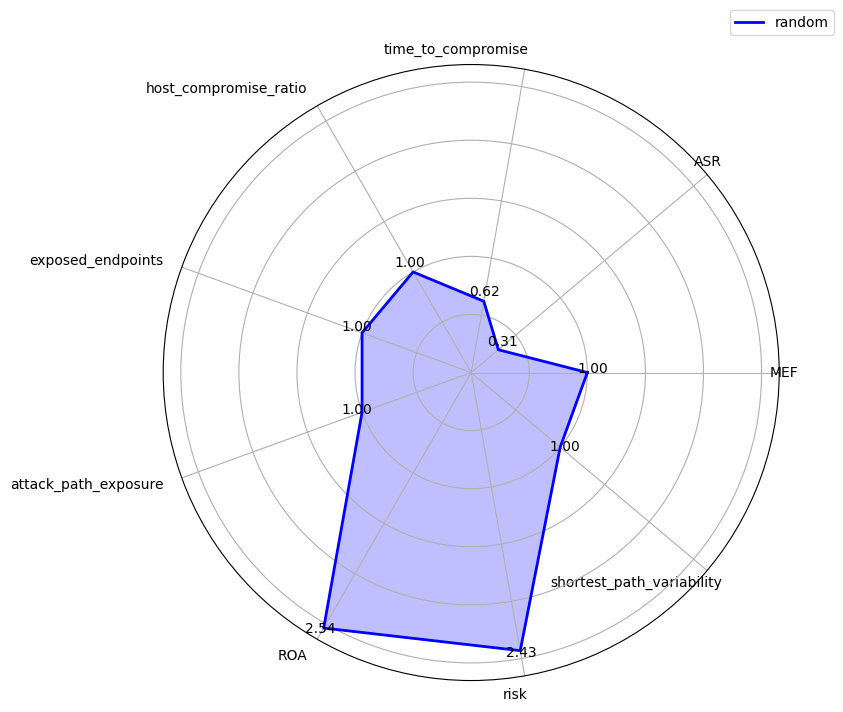

In [29]:

labels = ['MEF', 'ASR', 'time_to_compromise', 'host_compromise_ratio', 'exposed_endpoints', 'attack_path_exposure', 'ROA', 'risk', 'shortest_path_variability']
scheme = 'random'
scheme_result = radar.get_scheme_values(scheme)
scaled_metrics = radar.scale_metrics(scheme_result,radar.normalization_values)
# Assuming no standard deviation values for this example
radar.plot_single_radar(scheme=scheme,metrics_values=scaled_metrics)
# radar.plot_comparison_radar(radar.normalization_values)

In [31]:
scaled_metrics

{'MEF': 1,
 'ASR': 0.3053598120862695,
 'time_to_compromise': 0.6229981133514821,
 'host_compromise_ratio': 1.0,
 'exposed_endpoints': 1.0,
 'attack_path_exposure': 1.0,
 'ROA': 2.5400253294369897,
 'risk': 2.431557854399632,
 'shortest_path_variability': 1}